Data for the Microsoft (MSFT) Stocks downloaded from https://finance.yahoo.com/. The data spans from January 2016 to December 2020, a period of 5 years.

__Import Libraries and load dataset__

In [374]:
# import basic necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
import math

# import necessary libraries for LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
#from tensorflow.keras.layers import ConvLSTM2D

# import necessary libraries for Auto ARIMA
import scipy
import statsmodels.api as sm
import sklearn 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
#from pmdarima import auto_arima
import pmdarima as pm
from pmdarima import model_selection

In [60]:
# read the dataframe and display first 5 rows
df = read_csv('MSFT.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,54.320000,54.799999,53.389999,54.799999,49.591053,53778000
1,2016-01-05,54.930000,55.389999,54.540001,55.049999,49.817291,34079700
2,2016-01-06,54.320000,54.400002,53.639999,54.049999,48.912350,39518900
3,2016-01-07,52.700001,53.490002,52.070000,52.169998,47.211040,56564900
4,2016-01-08,52.369999,53.279999,52.150002,52.330002,47.355843,48754000


# Data Preprocessing

__Deal with potential missing values__

In [61]:
df.Date.describe()

count           1258
unique          1258
top       2018-08-13
freq               1
Name: Date, dtype: object

In [62]:
# change the type of data in the 'Date' column to date type
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [63]:
df.Date.describe()

<ipython-input-63-364f28f1a598>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.Date.describe()


count                    1258
unique                   1258
top       2016-09-08 00:00:00
freq                        1
first     2016-01-04 00:00:00
last      2020-12-30 00:00:00
Name: Date, dtype: object

In [64]:
# set the index to date
df.set_index("Date", inplace=True)

In [65]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,110.326200,111.389237,109.190231,110.351614,106.616404,2.947670e+07
std,50.396561,51.064228,49.706148,50.412510,51.131042,1.405551e+07
min,48.680000,49.150002,48.040001,48.430000,44.449955,7.425600e+06
25%,65.397499,65.750000,64.964998,65.472501,61.185489,2.063558e+07
50%,101.125000,101.904999,99.649997,101.130001,97.123665,2.569430e+07
75%,139.552497,140.375004,137.967499,139.052498,135.916901,3.361525e+07
max,229.270004,232.860001,227.350006,231.649994,229.124512,1.335030e+08


In [66]:
# set the frequency to business days
df = df.asfreq('b')

In [67]:
# check for missing values
df.isna().sum()

Open         45
High         45
Low          45
Close        45
Adj Close    45
Volume       45
dtype: int64

In [69]:
# frontfill the missing values (i.e. assign previous value in time series to each missing value)
df = df.fillna(method="ffill")

In [71]:
# check for missing values again
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

__Visualize the data for the Closing values__

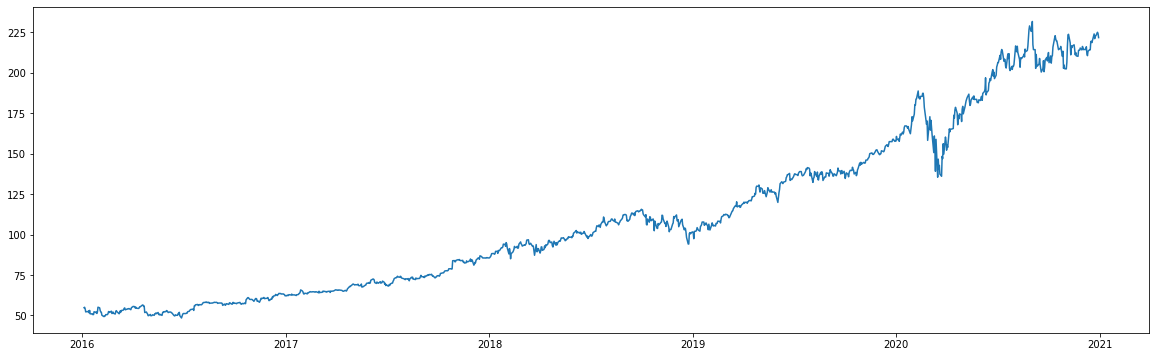

In [221]:
# plot the data
plt.plot(df.Close)

In [79]:
dataset = df.Close

In [80]:
dataset.head()

Date
2016-01-04    54.799999
2016-01-05    55.049999
2016-01-06    54.049999
2016-01-07    52.169998
2016-01-08    52.330002
Freq: B, Name: Close, dtype: float64

# LTSM

__Normalize the data for the Closing values__

In [104]:
#Convert the closing values from pandas dataframe to numpy array
dataset = df.Close.values
dataset = dataset.astype('float32')

In [105]:
dataset

array([ 54.8 ,  55.05,  54.05, ..., 224.96, 224.15, 221.68], dtype=float32)

In [106]:
# if this is not done, we get an error with 'scaler.fit_transform(dataset)'
dataset = dataset.reshape(-1,1)

In [107]:
dataset

array([[ 54.8 ],
       [ 55.05],
       [ 54.05],
       ...,
       [224.96],
       [224.15],
       [221.68]], dtype=float32)

In [108]:
# The values need to be normalized so they lie between 0 and 1
# LSTM uses the sigmoid and tanh functions which require normailzation
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

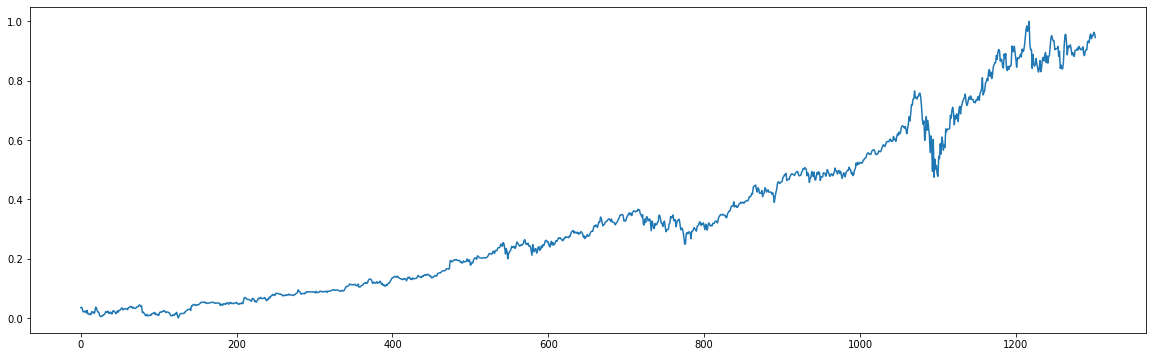

In [220]:
plt.plot(dataset)

__Create train and test data__

In [110]:
# split data into training and testing sets
# 80% of the data is used for training, the rest for testing
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train = dataset[0:train_size]
test = dataset[train_size:len(dataset)]

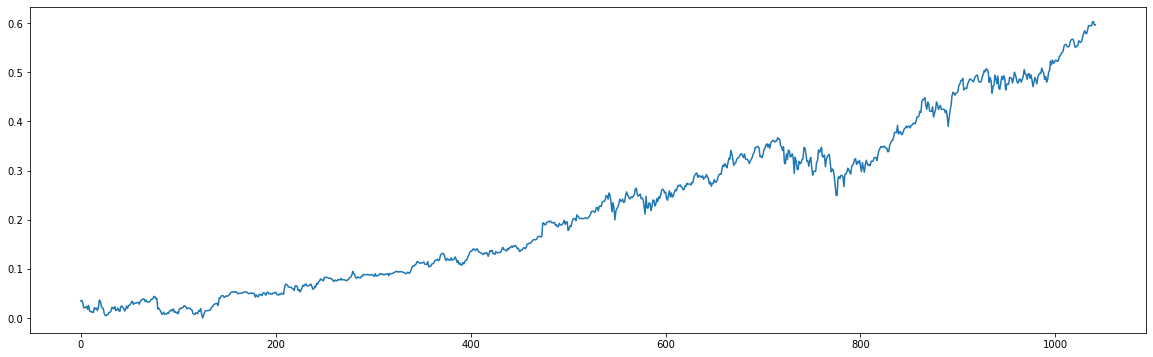

In [219]:
# visualize training data
plt.plot(train)

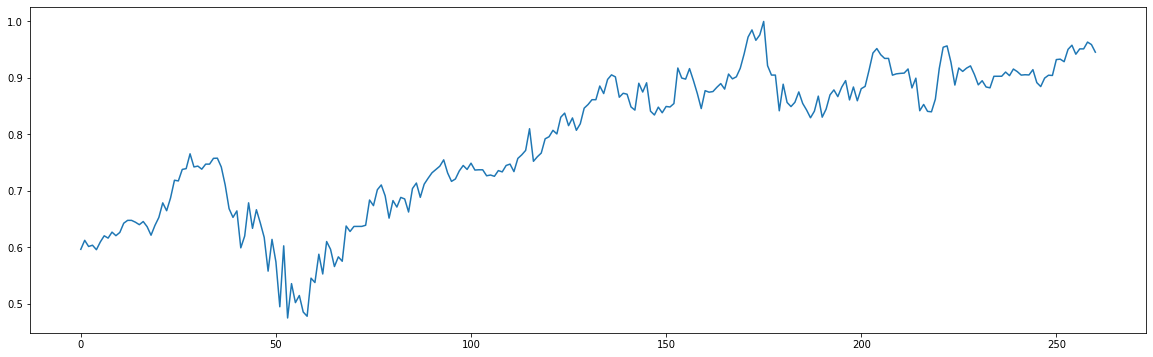

In [218]:
# visualize testing data
plt.plot(test)

__Convert time series to a supervised learning task with some lag observations as input and current observation as output__

In [125]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    
# Here we look at the past 10 business days (i.e. past 2 weeks) to predict tomorrow's closing value
seq_size = 10  

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Training set dimensions: {}".format(trainX.shape))
print("Test set dimensions: {}".format(testX.shape))

Training set dimensions: (1031, 10)
Test set dimensions: (250, 10)


In [126]:
# For input to our model, the data needs to be 3 dimensional in the form of [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

__Define Neural Network Architechture__

In [129]:
# arbitrarily define network architecture 

model = Sequential()
# single LSTM
# first layer with 50 neurons
model.add(LSTM(50, input_shape=(None, seq_size)))
# second layer with 25 neurons
model.add(Dense(25))
# final layer with one neuron/output
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
##monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
##                        verbose=1, mode='auto', restore_best_weights=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 13,501
Trainable params: 13,501
Non-trainable params: 0
_________________________________________________________________


__Train the Model and make predictions__

In [133]:
# fit the model
model.fit(trainX, trainY, validation_data=(testX, testY), verbose=1, epochs=100)

Epoch 1/100
33/33 [==============================] - 0s 3ms/step - loss: 5.2967e-05 - val_loss: 7.0896e-04
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 5.8331e-05 - val_loss: 7.3885e-04
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 5.3047e-05 - val_loss: 6.9012e-04
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 6.2724e-05 - val_loss: 7.1970e-04
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 5.2132e-05 - val_loss: 8.0983e-04
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 5.6894e-05 - val_loss: 6.1261e-04
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 5.2059e-05 - val_loss: 0.0012
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 6.6235e-05 - val_loss: 9.7117e-04
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 6.0533e-05 - val_loss: 6.0980e-04
Epoch 10/100
33/33 [=====================

Epoch 77/100
33/33 [==============================] - 0s 3ms/step - loss: 7.0409e-05 - val_loss: 6.4098e-04
Epoch 78/100
33/33 [==============================] - 0s 3ms/step - loss: 5.5535e-05 - val_loss: 7.7215e-04
Epoch 79/100
33/33 [==============================] - 0s 3ms/step - loss: 5.3606e-05 - val_loss: 6.2617e-04
Epoch 80/100
33/33 [==============================] - 0s 3ms/step - loss: 4.8955e-05 - val_loss: 6.1062e-04
Epoch 81/100
33/33 [==============================] - 0s 3ms/step - loss: 5.2158e-05 - val_loss: 6.1075e-04
Epoch 82/100
33/33 [==============================] - 0s 3ms/step - loss: 5.3683e-05 - val_loss: 6.4480e-04
Epoch 83/100
33/33 [==============================] - 0s 3ms/step - loss: 5.3944e-05 - val_loss: 6.1398e-04
Epoch 84/100
33/33 [==============================] - 0s 3ms/step - loss: 5.1049e-05 - val_loss: 6.3235e-04
Epoch 85/100
33/33 [==============================] - 0s 3ms/step - loss: 6.2993e-05 - val_loss: 6.0954e-04
Epoch 86/100
33/33 [========

In [134]:
# make predictions on training and testing data 

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [135]:
# invert predictions back to the original input values

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [140]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('RMSE of Training Data: %f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE of Testing Data: %f ' % (testScore))

RMSE of Training Data: 1.427837
RMSE of Testing Data: 5.516802 


__Plot the predictions__

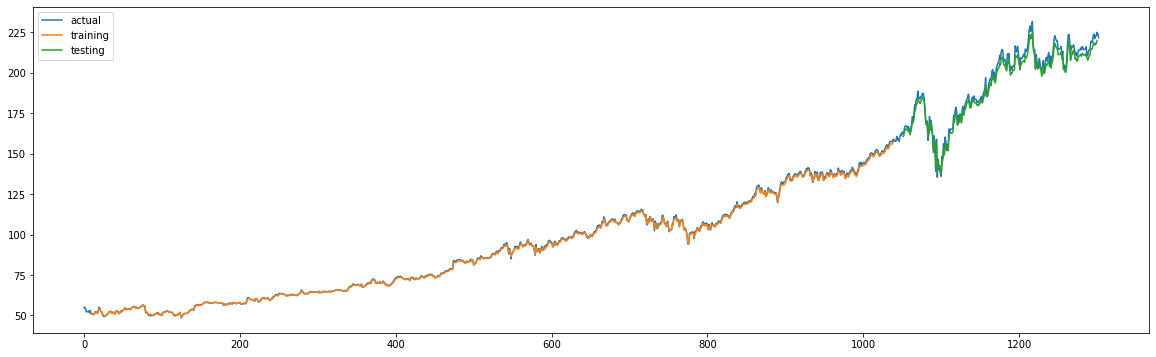

In [217]:
# shift trainnig data predictions for plotting so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size-1:len(trainPredict)+seq_size-1, :] = trainPredict

# shift testing data predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1-1:len(dataset)-1-1, :] = testPredict

# for adjusting size of the plot
plt.rcParams['figure.figsize'] = (20, 6)

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['actual','training','testing'])
#plt.ylim(100,200)
#plt.xlim(1100,1200)
plt.show()

# Auto ARIMA

In [339]:
# create new dataframe with only the closing prices
df1 = df[['Close']]

__Split the data into train and test points__

In [340]:
# split data into training and testing sets
# 80% of the data is used for training, the rest for testing
train_size = int(len(df1) * 0.8)
test_size = len(df1) - train_size
train = df1[0:train_size]
test = df1[train_size:len(df1)]

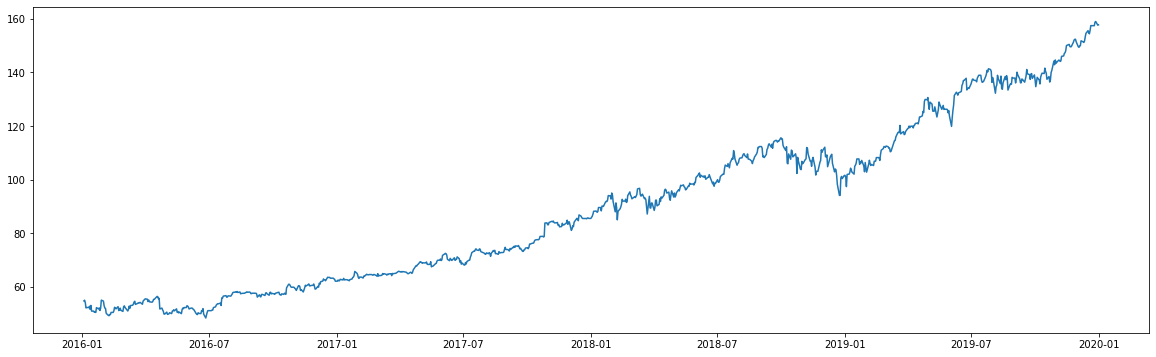

In [341]:
plt.plot(train.Close)

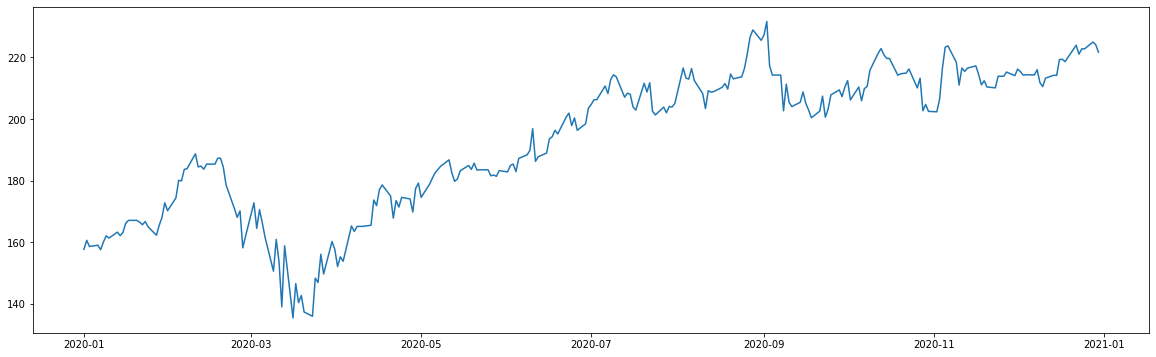

In [342]:
plt.plot(test.Close)

__Fit the ARIMA Model__

In [375]:
# Auto ARIMA
# information criterion is set to corrected AIC
arima_model = pm.auto_arima(train.Close, start_p=1, start_q=1, start_P=1, start_Q=1, max_p = 10, max_q = 10, max_d = 5, 
                        max_P = 5, max_Q = 5, max_D = 5, stepwise=True, maxiter=100, information_criterion="aicc", 
                        seasonal=True)

In [376]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1042
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1713.736
Date:                Mon, 03 Jan 2022   AIC                           3435.473
Time:                        22:48:33   BIC                           3455.265
Sample:                             0   HQIC                          3442.980
                               - 1042                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1243      0.040      3.138      0.002       0.047       0.202
ar.L1         -0.1176      0.021     -5.562      0.000      -0.159      -0.076
ar.L2         -0.1368      0.022     -6.221      0.000      -0.180      -0.094
sigma2         1.5755      0.041     38.890      0.000       1.496       1.655
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               710.46
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               6.12   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__Training and Testing RMSE__

In [369]:
# training and testing predictions
train_preds = pd.DataFrame(arima_model.predict(n_periods=train.shape[0]), index = train.index)
test_preds = pd.DataFrame(arima_model.predict(n_periods=test.shape[0]), index = test.index)

In [370]:
print("Training RMSE: %f" % np.sqrt(mean_squared_error(train.Close, train_preds)))

Training RMSE: 120.049676


In [371]:
print("Testing RMSE: %f" % np.sqrt(mean_squared_error(test.Close, test_preds)))

Testing RMSE: 27.695825


__Plot the Original and the predicted values__

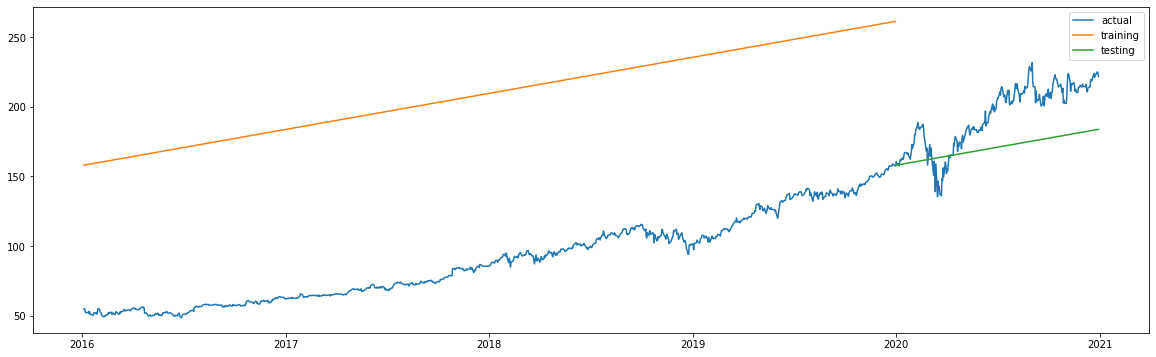

In [372]:
plt.plot(df.Close)
plt.plot(train_preds)
plt.plot(test_preds)
plt.legend(['actual','training','testing'])